# アンサンブル学習: バギング

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')


%matplotlib inline

In [2]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    """決定境界を可視化する関数"""
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=alpha)
    plt.axis(axes)

## Data Preparation

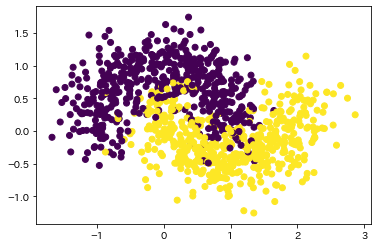

In [3]:
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

plt.scatter(X[:, 0], X[:, 1], c=y)

## Bagging
- MEMO:
    - BaggingClassifierは、ベースの分類器が確率を計算できるなら SoftVoting がデフォルトとなる

In [4]:
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                            n_estimators=500, # 500個の決定木をアンサンブル
                            max_samples=100, # 訓練セットから100個の訓練データを抽出する
                            bootstrap=True, # 重複ありで無作為にサンプリング(ブートストラップサンプリング)
                            n_jobs=-1)

bagging_clf.fit(X_train, y_train)

accuracy_score(y_test, bagging_clf.predict(X_test))

0.908

### 単独の決定木との比較

In [5]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

accuracy_score(y_test, tree_clf.predict(X_test))

0.892

### 決定境界
- バギングアンサンブルの方が汎化性能が高い

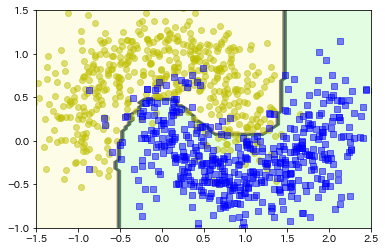

In [6]:
plot_decision_boundary(bagging_clf, X, y)

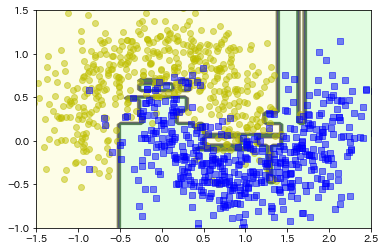

In [7]:
plot_decision_boundary(tree_clf, X, y)

## BaggingとPastingの違い
- バギングの方が、ペースティングよりもバイアスが少し高くなる傾向
    - 個々の予測器が訓練に使うサブセットの多様性が若干上がるため
        - バギングは復元抽出(=重複あり)なので、バリエーションが多いのは当然
    - 多様性があがるので、アンサンブルとしての分散は低下する(分散: 予測値のばらつきの大きさ)
        - よって、 バギングの方がペースティングよりも良いモデルになりやすい
        
            

### BaggingとPastingそれぞれにおける相関を見る

In [8]:
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                n_estimators=100,
                                max_samples=100,
                                bootstrap=True, # バギング(復元抽出)
                                n_jobs=-1)

bagging_clf.fit(X_train, y_train)


df_pred_bagging = pd.DataFrame()

for idx, clf in enumerate(bagging_clf.estimators_):
    df_pred_bagging[idx] = clf.predict(X_test)
    
    
accuracy_score(y_test, bagging_clf.predict(X_test))

0.912

In [9]:
pasting_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                n_estimators=100,
                                max_samples=100,
                                bootstrap=False, # ペースティング(非復元抽出)
                                n_jobs=-1)

pasting_clf.fit(X_train, y_train)


df_pred_pasting = pd.DataFrame()

for idx, clf in enumerate(pasting_clf.estimators_):
    df_pred_pasting[idx] = clf.predict(X_test)
    
accuracy_score(y_test, pasting_clf.predict(X_test))

0.912

Text(0.5, 1, 'Pasting (Corr: 0.719)')

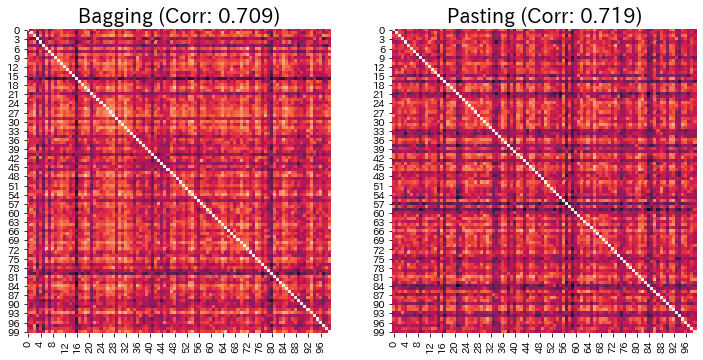

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

g1 = sns.heatmap(df_pred_bagging.corr(),
            square=True,
            cbar=False,
            ax=axes[0])

g2 = sns.heatmap(df_pred_pasting.corr(),
            square=True,
            cbar=False,
            ax=axes[1])

g1.set_title(f'Bagging (Corr: {df_pred_bagging.corr().mean().mean():.3f})', fontsize=20)
g2.set_title(f'Pasting (Corr: {df_pred_pasting.corr().mean().mean():.3f})', fontsize=20)

## OOB検証(Out-of-bag)
- バギングは復元抽出なので、サンプリングされない訓練サンプル(OOB: Out-of-bag)が生じる
    - 予測器の数が多くなると、OOBは約37%に近づく(訓練に使われるsampleは63%くらい)
    - 注意！ 37% はOOBの割合であって、全ての予測器で同じ37%が使わるわけではない
- OOBを利用することで、モデルの検証ができる(わざわざ検証セットを作らなくてよい)


In [11]:
np.random.seed(0)

bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                n_estimators=100,
                                max_samples=100,
                                bootstrap=True, # バギング(復元抽出)
                                oob_score=True, # OOB検証スコアを取得できる
                                n_jobs=-1)

bagging_clf.fit(X_train, y_train)

# OOB検証によるスコア
bagging_clf.oob_score_

0.9173333333333333

In [12]:
# OOB検証のスコアにかなり近い！
accuracy_score(y_test, bagging_clf.predict(X_test))

0.92

In [13]:
# 確率
bagging_clf.oob_decision_function_

array([[0.06976744, 0.93023256],
       [0.78823529, 0.21176471],
       [0.75903614, 0.24096386],
       ...,
       [0.43678161, 0.56321839],
       [0.98888889, 0.01111111],
       [0.15555556, 0.84444444]])

In [14]:
# 個々の訓練サンプルにおける確率は oob_decision_function_ で取得できる
bagging_clf.oob_decision_function_

array([[0.06976744, 0.93023256],
       [0.78823529, 0.21176471],
       [0.75903614, 0.24096386],
       ...,
       [0.43678161, 0.56321839],
       [0.98888889, 0.01111111],
       [0.15555556, 0.84444444]])